# Goal of this project

According to Experian research, 2017 saw more than a 30 percent increase in ecommerce fraud attacks compared to 2016. Key drivers of this change include a rapid expansion in the ecommerce market, increased spend in digital channels, and the rise of mobile payments. 

Using the advanced machine learning algorithms, we can help:
* _Reduce the cost though the increase of correct labels of fraud transaction_; 
* _Increase the revenue though the improvement customer experience with less false dectection_.

This project used a data set from an e-commerce company which sells electronic products.
The goal of this project contains:
* _Make classifications over a highly imbalanced (roughly 100:1) data set_
* _Perform correct feature engineering to extract more information from the data_
* _Made actionable recommendations for fraud detection system design_

# Takeaways of this project

__Fraud pattern__

Customers with the following features would have a higher risk of fraud:
* The purchase time interval after signing-up is less than or equal to 1 second.
* Use one device to make more than 2 transactions by different accounts
* Use a shared ip/public network 

__Fraud detection system design__

The probability estimated by GBM model could be transformed into a score for system automatically detect the customer with high risk of fraud:
* for a customer has a score rangring from 0 - 7, the order could pass to the shipping process
* for a customer has a score 8, the order should be taken manual investigation
* for a customer has a score 9 or 10, the order should be declined

In [107]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns


# Import dataset
fraud_data = pd.read_csv('imbalancedFraudDF.csv')
ip_country = pd.read_csv('IpAddress_to_Country.csv')


# Data Exploration

## Data Description
* time related features use GMT time;
* purchase_value is in USD;
* device_id is unique by device;
* source indicates users' marketing channel;

In [108]:
#Distribution of the label column
dist = fraud_data['class'].value_counts()
print(dist)
print('The normal class is',round(dist[0]/dist[1],1),'times more than the fraud class')
#highly imbalance

0    136961
1      1415
Name: class, dtype: int64
The normal class is 96.8 times more than the fraud class


In [109]:
fraud_data.head(10)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0
5,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0
6,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0
7,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0
8,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0
9,199700,2015-07-11 18:26:54,2015-10-28 21:59:40,13,TEPSJVVXGNTYR,Ads,Safari,F,35,1.819009e+09,0


In [110]:
fraud_data.shape

(138376, 11)

In [111]:
fraud_data.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

In [112]:
import pandas_profiling
# Data exploration
#Inline summary report without saving report as object
pandas_profiling.ProfileReport(fraud_data)

Number of variables,11
Number of observations,138376
Total Missing (%),0.0%
Total size in memory,11.6 MiB
Average record size in memory,88.0 B
Numeric,4
Categorical,5
Boolean,1
Date,0
Text (Unique),1
Rejected,0


## Check missing values, duplicates

In [113]:
# count of NaN in each column
fraud_data.isna().sum()
#fraud_data.isnull().sum(axis = 0)

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [114]:
# Check duplicates
print (fraud_data["user_id"].nunique())#138289
print (len(fraud_data.user_id))#138376
#This dataset only contains the first transaction of the customer

138376
138376


# Feature Engineering

## ip_address feature

In [115]:
#Identify country based on ip_address
ipToCountry = pd.read_csv('IpAddress_to_Country.csv')
ipToCountry.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [116]:
ip_address = fraud_data.loc[41, 'ip_address']
tmp = ipToCountry[(ipToCountry['lower_bound_ip_address'] <= ip_address) &
                    (ipToCountry['upper_bound_ip_address'] >= ip_address)]
print(tmp)

      lower_bound_ip_address  upper_bound_ip_address        country
2806             553648128.0               570425343  United States


In [117]:
start = time.time()

countries = []
for i in range(len(fraud_data)):
    ip_address = fraud_data.loc[i, 'ip_address']#number
    #below [] is list of T/F, tmp is a df of size n * 3, n = len(tmp) is 1 match or 0 no match
    tmp = ipToCountry[(ipToCountry['lower_bound_ip_address'] <= ip_address) &
                    (ipToCountry['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:#found match
        countries.append(tmp['country'].values[0])
    else:#no match
        countries.append('NA')
        
fraud_data['country'] = countries

fraud_data.head()
#Maybe later use binary search to optimize this process - too time-consuming 

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
3,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
4,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada


## Time related features

In [118]:
#time related features
fraud_data['interval_after_signup'] = (pd.to_datetime(fraud_data['purchase_time']) - pd.to_datetime(
        fraud_data['signup_time'])).dt.total_seconds()

fraud_data['signup_days_of_year'] = pd.DatetimeIndex(fraud_data['signup_time']).dayofyear

fraud_data['purchase_days_of_year'] = pd.DatetimeIndex(fraud_data['purchase_time']).dayofyear

fraud_data = fraud_data.drop(['user_id','signup_time','purchase_time'], axis=1)


In [119]:
fraud_data.head()

,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval_after_signup,signup_days_of_year,purchase_days_of_year
0,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0,55,108
1,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0,158,159
2,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,492085.0,118,124
3,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0,202,252
4,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,Canada,4240931.0,141,190


## Data split


In [120]:
y = fraud_data['class']
X = fraud_data.drop(['class'], axis=1)

#split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (110700, 11)
y_train.shape: (110700,)
X_test.shape: (27676, 11)
y_test.shape: (27676,)


In [121]:
X_train.head()

,purchase_value,device_id,source,browser,sex,age,ip_address,country,interval_after_signup,signup_days_of_year,purchase_days_of_year
34690,38,YIGJTAAYFASUL,Ads,IE,M,24,3.588130e+09,Hungary,409835.0,44,48
10270,44,IOKOPOIAVVKAS,Ads,FireFox,F,37,3.402400e+09,China,249746.0,126,129
41408,29,BVTVIZNOQGJNI,Ads,Chrome,M,52,3.884563e+09,NA,3374159.0,37,76
43632,52,VPSYSNDACXJJU,SEO,FireFox,F,25,1.884616e+09,China,4880497.0,158,214
46184,46,EOWKGZUJKDRWX,Ads,Safari,F,40,2.887479e+09,NA,4592867.0,47,100


In [122]:
X_train.dtypes

purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
country                   object
interval_after_signup    float64
signup_days_of_year        int64
purchase_days_of_year      int64
dtype: object

## Convert categorical features with less than 4 classes using one-hot encoding

In [123]:
#One hot encoding for source and browser features

#Training set
X_train = pd.get_dummies(X_train, columns=['source', 'browser'])
X_train['sex'] = (X_train.sex == 'M').astype(int)

#Testing set
X_test = pd.get_dummies(X_test, columns=['source', 'browser'])
X_test['sex'] = (X_test.sex == 'M').astype(int)

## Convert categorical features with high cadinality to numericals

In [124]:
#Using assumptions to transfer

#Training set
# the more a device is shared, the more suspicious(larger chance to be fraud)
X_train['n_dev_shared'] = X_train.device_id.map(X_train.device_id.value_counts(dropna=False))

# the more a ip is shared, the more suspicious
X_train['n_ip_shared'] = X_train.ip_address.map(X_train.ip_address.value_counts(dropna=False))

# the less visit from a country, the more suspicious
X_train['n_country_shared'] = X_train.country.map(X_train.country.value_counts(dropna=False))#lots of NAs in country column, #without dropna=False will produce nan in this col

X_train = X_train.drop(['device_id','ip_address','country'], axis=1)


#Testing set
# the more a device is shared, the more suspicious
X_test['n_dev_shared'] = X_test.device_id.map(X_test.device_id.value_counts(dropna=False))

# the more a ip is shared, the more suspicious
X_test['n_ip_shared'] = X_test.ip_address.map(X_test.ip_address.value_counts(dropna=False))

# the less visit from a country, the more suspicious
X_test['n_country_shared'] = X_test.country.map(X_test.country.value_counts(dropna=False))

X_test = X_test.drop(['device_id','ip_address','country'], axis=1)


In [125]:
X_train.head(10)

,purchase_value,sex,age,interval_after_signup,signup_days_of_year,purchase_days_of_year,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,n_dev_shared,n_ip_shared,n_country_shared
34690,38,1,24,409835.0,44,48,1,0,0,0,0,1,0,0,1,1,158
10270,44,0,37,249746.0,126,129,1,0,0,0,1,0,0,0,1,1,8925
41408,29,1,52,3374159.0,37,76,1,0,0,1,0,0,0,0,1,1,16178
43632,52,0,25,4880497.0,158,214,0,0,1,0,1,0,0,0,1,1,8925
46184,46,0,40,4592867.0,47,100,1,0,0,0,0,0,0,1,1,1,16178
84073,49,0,39,1149725.0,16,29,0,0,1,0,0,0,0,1,1,1,8925
99208,63,1,55,5955233.0,56,125,0,1,0,1,0,0,0,0,1,1,442
86580,65,1,42,10295893.0,207,326,0,1,0,1,0,0,0,0,1,1,2724
17308,27,1,31,8697410.0,67,168,1,0,0,1,0,0,0,0,1,1,8925
131420,31,1,36,1294172.0,212,227,1,0,0,0,0,0,0,1,1,1,42487


In [126]:
X_test.head(10)

,purchase_value,sex,age,interval_after_signup,signup_days_of_year,purchase_days_of_year,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,n_dev_shared,n_ip_shared,n_country_shared
37552,15,1,23,1050536.0,162,174,1,0,0,0,1,0,0,0,1,1,10536
54487,95,0,32,4411461.0,17,68,0,1,0,0,0,1,0,0,1,1,46
65023,41,0,37,9506216.0,218,328,0,1,0,1,0,0,0,0,1,1,10536
118720,39,0,28,9935639.0,71,186,0,0,1,0,0,0,0,1,1,1,1363
4365,10,0,37,7825379.0,80,171,1,0,0,1,0,0,0,0,1,1,4113
123639,29,0,43,972765.0,172,184,0,0,1,0,0,1,0,0,2,1,10536
45549,10,1,47,6228801.0,83,155,1,0,0,0,0,1,0,0,1,1,4113
136990,17,0,26,1.0,4,4,1,0,0,1,0,0,0,0,1,1,10536
112716,65,1,22,9296066.0,165,273,1,0,0,0,0,0,0,1,1,1,4113
22885,33,0,31,7134667.0,207,290,0,0,1,0,0,1,0,0,1,1,521


## Scale


In [28]:
#Normalization: (min-max) to [0,1]
#Using normalization since it would give us the positive columns

#Compute the train minimum and maximum to be used for later scaling:
scaler = preprocessing.MinMaxScaler().fit(X_train[['n_dev_shared', 'n_ip_shared', 'n_country_shared']]) 
#print(scaler.data_max_)

#transform the training data and use them for the model training
X_train[['n_dev_shared', 'n_ip_shared', 'n_country_shared']] = scaler.transform(X_train[['n_dev_shared', 'n_ip_shared', 'n_country_shared']])

#before the prediction of the test data, apply the same scaler obtained from above on X_test, not fitting a brandnew scaler on test
X_test[['n_dev_shared', 'n_ip_shared', 'n_country_shared']] = scaler.transform(X_test[['n_dev_shared', 'n_ip_shared', 'n_country_shared']])


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [29]:
X_train.n_dev_shared.value_counts(dropna=False)

0.0    105351
0.2      4872
0.4       306
0.6       120
0.8        45
1.0         6
Name: n_dev_shared, dtype: int64

In [30]:
X_test.n_dev_shared.value_counts(dropna=False)

0.0    27311
0.2      350
0.4       15
Name: n_dev_shared, dtype: int64

In [35]:
X_train.dtypes

purchase_value             int64
sex                        int64
age                        int64
interval_after_signup    float64
signup_days_of_year        int64
purchase_days_of_year      int64
source_Ads                 uint8
source_Direct              uint8
source_SEO                 uint8
browser_Chrome             uint8
browser_FireFox            uint8
browser_IE                 uint8
browser_Opera              uint8
browser_Safari             uint8
n_dev_shared             float64
n_ip_shared              float64
n_country_shared         float64
dtype: object

In [32]:
X_train.head()

,purchase_value,sex,age,interval_after_signup,signup_days_of_year,purchase_days_of_year,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,n_dev_shared,n_ip_shared,n_country_shared
34690,38,1,24,409835.0,44,48,1,0,0,0,0,1,0,0,0.0,0.0,0.003695
10270,44,0,37,249746.0,126,129,1,0,0,0,1,0,0,0,0.0,0.0,0.210046
41408,29,1,52,3374159.0,37,76,1,0,0,1,0,0,0,0,0.0,0.0,0.380761
43632,52,0,25,4880497.0,158,214,0,0,1,0,1,0,0,0,0.0,0.0,0.210046
46184,46,0,40,4592867.0,47,100,1,0,0,0,0,0,0,1,0.0,0.0,0.380761


## Correlation matrix

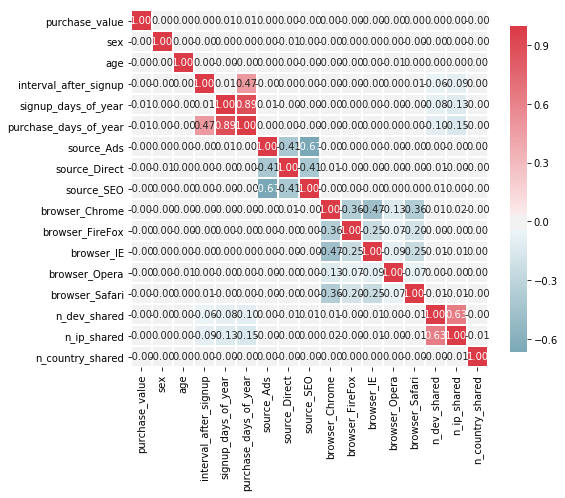

In [36]:
#corelation matrix for continuous column
correlations = X_train.corr()

# Create color map ranging between two colors
cmap = sns.diverging_palette(220, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
plt.show();
#No abnormal features

# Modeling

## Baseline logistic regression

In [40]:
logistic = LogisticRegression()

# fit the model with data
logistic.fit(X_train,y_train)

# predict on test
y_pred=logistic.predict(X_test)

# generate class probabilities
probs = logistic.predict_proba(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [48]:
# evaluation metrics
print ("confusion_matrix is: ")
cm = metrics.confusion_matrix(y_test, y_pred)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1]))
print ('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print ('precision =', 0)
print("F1 score is:",0)

confusion_matrix is: 
        pred_0  pred_1
true_0   27380       0
true_1     296       0
roc_auc_score is:  0.7563902310820683
recall = 0.0
precision = 0
F1 score is: 0


## Random Forest

In [101]:
classifier_RF = RandomForestClassifier(random_state=41)

classifier_RF.fit(X_train, y_train)

# predict class labels 0/1 for the test set
predicted = classifier_RF.predict(X_test)

# generate class probabilities
probs = classifier_RF.predict_proba(X_test)


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [102]:
# evaluation metrics
print ("confusion_matrix is: ")
cm = confusion_matrix(y_test, predicted)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)

print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1])))
print ('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print ('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))
print("%s: %r" % ("f1_score is: ", f1_score(y_test, predicted )))


confusion_matrix is: 
        pred_0  pred_1
true_0   27380       0
true_1     139     157
roc_auc_score is: : 0.7563902310820683
recall = 0.5304054054054054
precision = 1.0
f1_score is: : 0.6931567328918322


In [88]:
# table of model performance
model_performance = pd.DataFrame({'Model':["Baseline","Tuned Logistic Regression","Random Forest","Tuned Random Forest","Gradient Boosting"],
                                  'Recall':[0,0,0,0,0], 
                                  'F1 score':[0,0,0,0,0]})
model_performance.iloc[2,1] = round(0.5304054054054054,4)
model_performance.iloc[2,2] = round(0.6931567328918322,4)
print(model_performance)


                       Model  Recall  F1 score
0                   Baseline  0.0000    0.0000
1  Tuned Logistic Regression  0.0000    0.0000
2              Random Forest  0.5304    0.6932
3        Tuned Random Forest  0.0000    0.0000
4          Gradient Boosting  0.0000    0.0000


## XGBoost

In [137]:
# matrix
#D_train = xgb.DMatrix(X_train, label = y_train)
#D_test = xgb.DMatrix(X_test, label= y_test)
# fit the xgb model
classifier_xgb = xgb.XGBRegressor(objective ='binary:logistic',random_state=0)
classifier_xgb.fit(X_train,y_train)
# predict class labels for the test set
y_preds = classifier_xgb.predict(X_test)
predicted = [round(value) for value in y_preds]


/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [138]:
# evaluation metrics
print ("confusion_matrix is: ")
cm = confusion_matrix(y_test, predicted)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)

print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, y_preds)))
print ('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print ('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))
print("%s: %r" % ("f1_score is: ", f1_score(y_test, predicted )))

confusion_matrix is: 
        pred_0  pred_1
true_0   27380       0
true_1     139     157
roc_auc_score is: : 0.7681741456577103
recall = 0.5304054054054054
precision = 1.0
f1_score is: : 0.6931567328918322


## Resampling

### Oversampling

In [59]:
smote = SMOTE(random_state=41)
x_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)

unique, counts = np.unique(y_train_sm, return_counts=True)

print (np.asarray((unique, counts)).T)

[[     0 109581]
 [     1 109581]]


In [97]:
#RF on smoted training data
classifier_RF_sm = RandomForestClassifier(random_state=41)

classifier_RF_sm.fit(x_train_sm, y_train_sm)

# predict class labels for the test set
predicted_sm = classifier_RF_sm.predict(X_test)

# generate class probabilities
probs_sm = classifier_RF_sm.predict_proba(X_test)


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [98]:
# evaluation metrics
print ("confusion_matrix is: ")
cm = confusion_matrix(y_test, predicted_sm)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)

print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs_sm[:, 1])))
print ('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print ('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))
print("%s: %r" % ("f1_score is: ", f1_score(y_test, predicted_sm )))

confusion_matrix is: 
        pred_0  pred_1
true_0   20470    6910
true_1     107     189
roc_auc_score is: : 0.7436320405504117
recall = 0.6385135135135135
precision = 0.02662346809409776
f1_score is: : 0.05111561866125761


### Undersampling

In [62]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=41)
x_train_us, y_train_us = rus.fit_sample(X_train, y_train)

unique, counts = np.unique(y_train_us, return_counts=True)

print (np.asarray((unique, counts)).T)

[[   0 1119]
 [   1 1119]]


In [65]:
#RF on smoted training data
classifier_RF_us = RandomForestClassifier(random_state=0)

classifier_RF_us.fit(x_train_us, y_train_us)

# predict class labels for the test set
predicted_us = classifier_RF_us.predict(X_test)

# generate class probabilities
probs_us = classifier_RF_us.predict_proba(X_test)


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [66]:
# evaluation metrics
print ("confusion_matrix is: ")
cm = confusion_matrix(y_test, predicted_us)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)

print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs_us[:, 1])))
print ('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print ('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))
print("%s: %r" % ("f1_score is: ", f1_score(y_test, predicted_us)))

confusion_matrix is: 
        pred_0  pred_1
true_0   22030    5350
true_1     106     190
roc_auc_score is: : 0.7693351084832093
recall = 0.6418918918918919
precision = 0.03429602888086643
f1_score is: : 0.06511309115832763


### What I learned
* Although the resampling strategy did improve the recall a lot, it also increase the False Positive rate dramatically. 
* I decided not to use resampling for furture modeling since this strategt would cause normal customers to be targeted as fraud and cancel their transaction, which would lead to low customer satisfaction in reality.

## Parameter tuning 

### Evaluation metrics for grid search

In [154]:
# Eval metrics to be calculated for each combination of parameters and cv
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score, pos_label=1)
}

In [155]:
def grid_search_wrapper(model, parameters, refit_score='f1_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization(refit on the best model according to refit_score)
    prints classifier performance metrics
    """
#     skf = StratifiedKFold(n_splits=10)
#     grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
#                            cv=skf, return_train_score=True, n_jobs=-1)
    grid_search = GridSearchCV(model, parameters, scoring=scorers, refit=refit_score,
                           cv=3, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)
    y_prob = grid_search.predict_proba(X_test)[:, 1]
    
    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    cm = confusion_matrix(y_test, y_pred)
    cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
    print(cmDF)
    
    print("\t%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, y_prob)))
    print("\t%s: %r" % ("f1_score is: ", f1_score(y_test, y_pred)))#string to int

    print ('recall = ', float(cm[1,1]) / (cm[1,0] + cm[1,1]))
    print ('precision = ', float(cm[1,1]) / (cm[1, 1] + cm[0,1]))

    return grid_search


### Optimizing over f1_score on LR

In [73]:
LRGrid = {'C': [0.01, 0.1, 1, 10, 100], "penalty":["l1","l2"]}#  smaller C specify stronger regularization, l1 lasso l2 ridge

logRegModel = LogisticRegression(random_state=0)

grid_search_LR_f1 = grid_search_wrapper(logRegModel, LRGrid, refit_score='f1_score')

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best params for f1_score
{'C': 0.1, 'penalty': 'l1'}

Confusion matrix of Random Forest optimized for f1_score on the test data:
        pred_0  pred_1
true_0   20612    6768
true_1     223      73
	roc_auc_score is: : 0.6601139123052928
	f1_score is: : 0.020456774555135216
recall =  0.24662162162162163
precision =  0.010670954538810116


In [90]:
model_performance.iloc[1,1] = round(0.24662162162162163,4)
model_performance.iloc[1,2] = round(0.020456774555135216,4)
print(model_performance)

                       Model  Recall  F1 score
0                   Baseline  0.0000    0.0000
1  Tuned Logistic Regression  0.2466    0.0205
2              Random Forest  0.5304    0.6932
3        Tuned Random Forest  0.0000    0.0000
4          Gradient Boosting  0.0000    0.0000


### Optimizing over f1_score on RF

In [207]:
parameters = {        
'max_depth': [None,10,20,30],
'n_estimators' :  [50,100],
'class_weight' : [{0: 1, 1: w} for w in [0.05,0.1,0.2]]
}

clf = RandomForestClassifier(random_state=41)

In [208]:
grid_search_rf_f1 = grid_search_wrapper(clf, parameters, refit_score='f1_score')

Best params for f1_score
{'class_weight': {0: 1, 1: 0.1}, 'max_depth': 10, 'n_estimators': 100}

Confusion matrix of Random Forest optimized for f1_score on the test data:
        pred_0  pred_1
true_0   27380       0
true_1     139     157
	roc_auc_score is: : 0.7727052198290328
	f1_score is: : 0.6931567328918322
recall =  0.5304054054054054
precision =  1.0


In [81]:
# print result of grid search
results_f1 = pd.DataFrame(grid_search_rf_f1.cv_results_)
results_sortf1 = results_f1.sort_values(by='mean_test_f1_score', ascending=False)
results_sortf1[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_f1_score', 'mean_train_precision_score', 'mean_train_recall_score', 'mean_train_f1_score','param_max_depth', 'param_class_weight', 'param_n_estimators']].round(3).head(10)



,mean_test_precision_score,mean_test_recall_score,mean_test_f1_score,mean_train_precision_score,mean_train_recall_score,mean_train_f1_score,param_max_depth,param_class_weight,param_n_estimators
0,1.0,0.52,0.684,1.0,0.976,0.988,None,"{0: 1, 1: 0.05}",50
1,1.0,0.52,0.684,1.0,0.998,0.999,None,"{0: 1, 1: 0.05}",100
22,1.0,0.52,0.684,1.0,0.975,0.987,30,"{0: 1, 1: 0.2}",50
21,1.0,0.52,0.684,1.0,0.746,0.854,20,"{0: 1, 1: 0.2}",100
20,1.0,0.52,0.684,1.0,0.755,0.860,20,"{0: 1, 1: 0.2}",50
19,1.0,0.52,0.684,1.0,0.520,0.684,10,"{0: 1, 1: 0.2}",100
18,1.0,0.52,0.684,1.0,0.521,0.685,10,"{0: 1, 1: 0.2}",50
17,1.0,0.52,0.684,1.0,0.998,0.999,None,"{0: 1, 1: 0.2}",100
16,1.0,0.52,0.684,1.0,0.978,0.989,None,"{0: 1, 1: 0.2}",50
15,1.0,0.52,0.684,1.0,0.996,0.998,30,"{0: 1, 1: 0.1}",100


In [209]:
best_rf_model_f1 = grid_search_rf_f1.best_estimator_
best_rf_model_f1

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 0.1},
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=41, verbose=0, warm_start=False)

In [269]:
classifier_RF = RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 0.1},
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=41, verbose=0, warm_start=False)

classifier_RF.fit(X_train, y_train)

# predict class labels 0/1 for the test set
predicted = classifier_RF.predict(X_test)

# generate class probabilities
probs = classifier_RF.predict_proba(X_test)

# generate evaluation metrics
print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, predicted)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1])))
print("%s: %r" % ("f1_score is: ", f1_score(y_test, predicted )))#string to int

print ("confusion_matrix is: ")
cm = confusion_matrix(y_test, predicted)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print ('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print ('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))#1.0

accuracy_score is: : 0.9949775979187744
roc_auc_score is: : 0.7727052198290328
f1_score is: : 0.6931567328918322
confusion_matrix is: 
        pred_0  pred_1
true_0   27380       0
true_1     139     157
recall = 0.5304054054054054
precision = 1.0


In [211]:
#Var Importance
pd.DataFrame(best_rf_model_f1.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)


,importance
interval_after_signup,0.626935
purchase_days_of_year,0.164922
n_ip_shared,0.066951
n_dev_shared,0.061697
signup_days_of_year,0.028046
age,0.013553
purchase_value,0.013321
n_country_shared,0.009937
sex,0.002719
browser_Chrome,0.002112


Text(0, 0.5, 'Feature Importance Score')

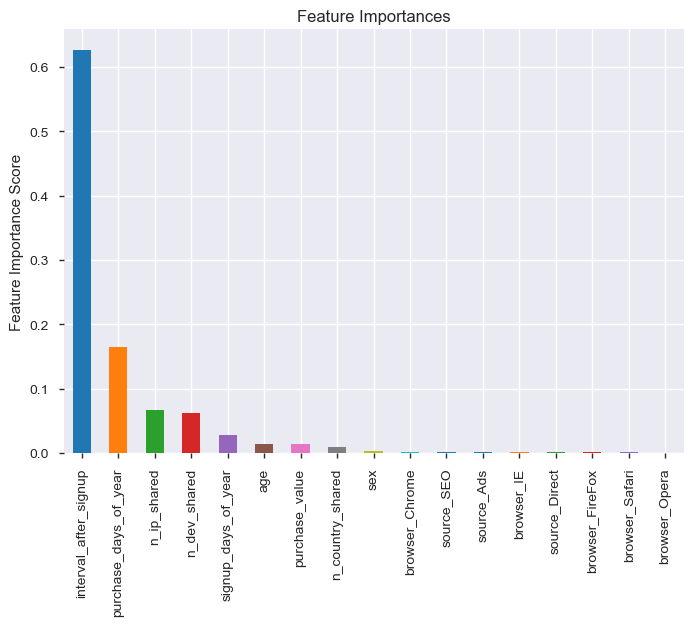

In [212]:
predictors = [x for x in X_train.columns]
feat_imp = pd.Series(best_rf_model_f1.feature_importances_,predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [32]:
X_train.head()

,purchase_value,sex,age,interval_after_signup,signup_days_of_year,purchase_days_of_year,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,n_dev_shared,n_ip_shared,n_country_shared
34690,38,1,24,409835.0,44,48,1,0,0,0,0,1,0,0,0.0,0.0,0.003695
10270,44,0,37,249746.0,126,129,1,0,0,0,1,0,0,0,0.0,0.0,0.210046
41408,29,1,52,3374159.0,37,76,1,0,0,1,0,0,0,0,0.0,0.0,0.380761
43632,52,0,25,4880497.0,158,214,0,0,1,0,1,0,0,0,0.0,0.0,0.210046
46184,46,0,40,4592867.0,47,100,1,0,0,0,0,0,0,1,0.0,0.0,0.380761


In [93]:
# update the table
model_performance.iloc[3,1] = round(float(cm[1,1])/(cm[1,0]+cm[1,1]),4)
model_performance.iloc[3,2] = round(f1_score(y_test, predicted),4)
print(model_performance)

                       Model  Recall  F1 score
0                   Baseline  0.0000    0.0000
1  Tuned Logistic Regression  0.2466    0.0205
2              Random Forest  0.5304    0.6932
3        Tuned Random Forest  0.5304    0.6932
4          Gradient Boosting  0.0000    0.0000


### Optimizing over f1_score on GBM

In [199]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm

* min_samples_split = 140 
This should be ~0.5-1% of total values. Since this is imbalanced class problem, we’ll take a small value from the range.
* min_samples_leaf = 30 
Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.
* max_depth = 8 
Should be chosen (5-8) based on the number of observations and predictors. This has 110K rows and 17 columns so lets take 8 here.
* max_features = ‘sqrt’ : 
Its a general thumb-rule to start with square root.
* subsample = 0.8 : This is a commonly used used start value

In [159]:
# Fix learning rate and number of estimators for tuning tree-based parameters
# tune the 'n_estimators' with learning rate = 0.1
param_test1 = {'n_estimators':range(20,101,20)}
gsearch1 = GridSearchCV(scoring="f1", estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=140,min_samples_leaf=30,max_depth=8,max_features='sqrt',subsample=0.8,random_state=41), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=30, min_sa...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(20, 101, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [162]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 60}, 0.8202078312259964)

In [182]:
# Tuning tree-specific parameters
param_test2 = {'max_depth':range(3,9), 'min_samples_split':range(100,501,100)}

gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=41), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch2.best_score_
#max_depth = 5, min_samples_split = 40

({'max_depth': 7, 'min_samples_split': 100}, 0.8274970948007383)

In [183]:
#
param_test3 = {'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=7, min_samples_split = 100,max_features='sqrt', subsample=0.8, random_state=41), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_


({'min_samples_leaf': 60}, 0.8214073955055989)

In [184]:
param_test4 = {'max_features':range(4,18,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=7, min_samples_split = 100, min_samples_leaf = 60, subsample=0.8, random_state=41),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train,y_train)
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 10}, 0.8219777652296021)

In [185]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=5, min_samples_split = 300, min_samples_leaf = 60, max_features = 10,subsample=0.8, random_state=41),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train,y_train)
gsearch5.best_params_, gsearch5.best_score_

({'subsample': 0.75}, 0.8239959524626718)

In [273]:
gbm_tuned = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=5, min_samples_split = 300, min_samples_leaf = 60, max_features = 10,subsample=0.75, random_state=41)
gbm_tuned.fit(X_train, y_train)

# predict class labels 0/1 for the test set
predicted = gbm_tuned.predict(X_test)

# generate class probabilities
probs = gbm_tuned.predict_proba(X_test)
  
# generate evaluation metrics
print("%s: %r" % ("accuracy_score is: ", accuracy_score(y_test, predicted)))
print("%s: %r" % ("roc_auc_score is: ", roc_auc_score(y_test, probs[:, 1])))
print("%s: %r" % ("f1_score is: ", f1_score(y_test, predicted )))#string to int

print ("confusion_matrix is: ")
cm = confusion_matrix(y_test, predicted)
cmDF = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_0', 'true_1'])
print(cmDF)
print ('recall =',float(cm[1,1])/(cm[1,0]+cm[1,1]))
print ('precision =', float(cm[1,1])/(cm[1,1] + cm[0,1]))#1.0

accuracy_score is: : 0.9949775979187744
roc_auc_score is: : 0.7762515300179653
f1_score is: : 0.6931567328918322
confusion_matrix is: 
        pred_0  pred_1
true_0   27380       0
true_1     139     157
recall = 0.5304054054054054
precision = 1.0


In [274]:
# update the table
model_performance.iloc[4,1] = round(float(cm[1,1])/(cm[1,0]+cm[1,1]),4)
model_performance.iloc[4,2] = round(f1_score(y_test, predicted),4)
print(model_performance)

                       Model  Recall  F1 score
0                   Baseline  0.0000    0.0000
1  Tuned Logistic Regression  0.2466    0.0205
2              Random Forest  0.5304    0.6932
3        Tuned Random Forest  0.5304    0.6932
4          Gradient Boosting  0.5304    0.6932


Text(0, 0.5, 'Feature Importance Score')

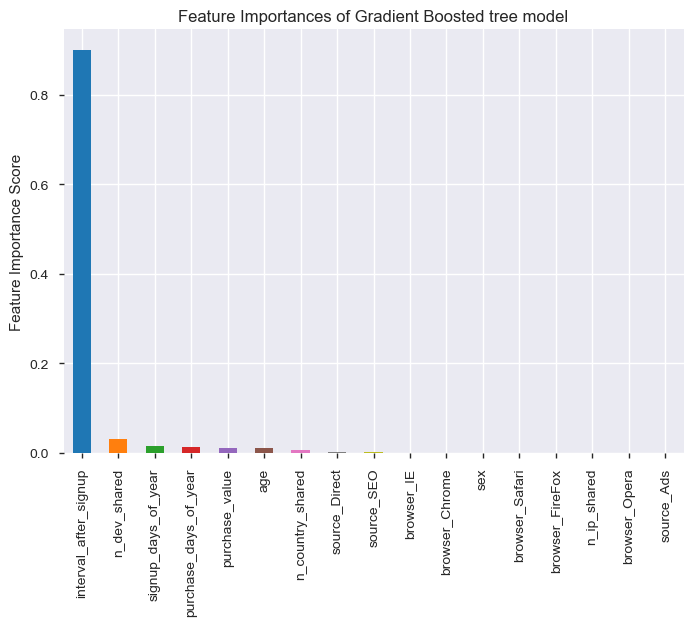

In [271]:
feat_imp = pd.Series(gbm_tuned.feature_importances_,predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances of Gradient Boosted tree model')
plt.ylabel('Feature Importance Score')
    

Text(0, 0.5, 'Feature Importance Score')

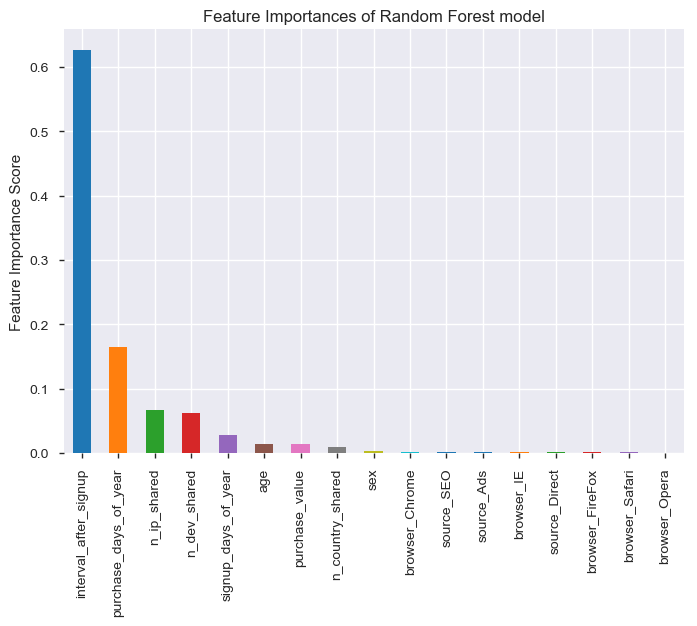

In [272]:
predictors = [x for x in X_train.columns]
feat_imp = pd.Series(best_rf_model_f1.feature_importances_,predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances of Random Forest model')
plt.ylabel('Feature Importance Score')

# Model Inference - Learn from the best model

## Model selection

In [275]:
print(model_performance)

                       Model  Recall  F1 score
0                   Baseline  0.0000    0.0000
1  Tuned Logistic Regression  0.2466    0.0205
2              Random Forest  0.5304    0.6932
3        Tuned Random Forest  0.5304    0.6932
4          Gradient Boosting  0.5304    0.6932


* Based on the model performance table, it can beseen that there is no big difference between random forest and GBM model
* considering Boosted Trees(GBM) tries to add new trees that compliments the already built ones, which leads to better accuracy with less trees, I decided to propose GBM as the optimal model in this project

Based on the variable importance plots, we can find:
* interval_after_signup feature dominates the predictive performance in both tuned models
* number of device shared, number of ip shared, the day of year purchased, the day of year signed up and age also siginificantly influence the classification.

In [ ]:
train = pd.concat([X_train, y_train], axis=1)
fraud = train[train['class'] == 1]

In [218]:
fraud_data.groupby("class")[['interval_after_signup']].median()


,interval_after_signup
class,
0,5194911.0
1,1.0


In [264]:
fraud.describe()

,purchase_value,sex,age,interval_after_signup,signup_days_of_year,purchase_days_of_year,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,n_dev_shared,n_ip_shared,n_country_shared,class
count,1119.000000,1119.000000,1119.000000,1.119000e+03,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.0
mean,37.252904,0.584450,33.540661,2.592738e+06,57.111707,87.130474,0.389634,0.213584,0.396783,0.453977,0.164433,0.201966,0.018767,0.160858,2.027703,1.863271,19465.602324,1.0
std,19.063481,0.493037,8.769249,3.413887e+06,69.815493,97.686627,0.487885,0.410019,0.489449,0.498100,0.370833,0.401647,0.135761,0.367564,1.085826,1.098902,18184.374962,0.0
min,9.000000,0.000000,18.000000,1.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,27.000000,1.0
25%,22.000000,0.000000,27.000000,1.000000e+00,6.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2168.000000,1.0
50%,34.000000,1.000000,33.000000,1.000000e+00,11.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,16178.000000,1.0
75%,49.500000,1.000000,39.000000,5.184916e+06,103.500000,169.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,42487.000000,1.0
max,111.000000,1.000000,64.000000,1.035400e+07,229.000000,344.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,6.000000,42487.000000,1.0


* more than half of fraud happened 1s after signed up, which is abnormal.

In [214]:
# Deeper dive into number of device shared
train = pd.concat([X_train, y_train], axis=1)
pd.crosstab(train["n_dev_shared"],train["class"])

class,0,1
n_dev_shared,,
1,104917,434
2,4488,384
3,128,178
4,33,87
5,14,31
6,1,5


* It can be seen that when the number of shared devices is more than 2, the possibility of fraud is increasingly higher.

In [219]:
# Deeper dive into number of ip shared
train = pd.concat([X_train, y_train], axis=1)
pd.crosstab(train["n_ip_shared"],train["class"])

class,0,1
n_ip_shared,,
1,109278,584
2,195,247
3,74,175
4,28,88
5,5,20
6,1,5


* It can be seen that when the customer used a shared/public ip, the possibility of fraud is increasingly higher.

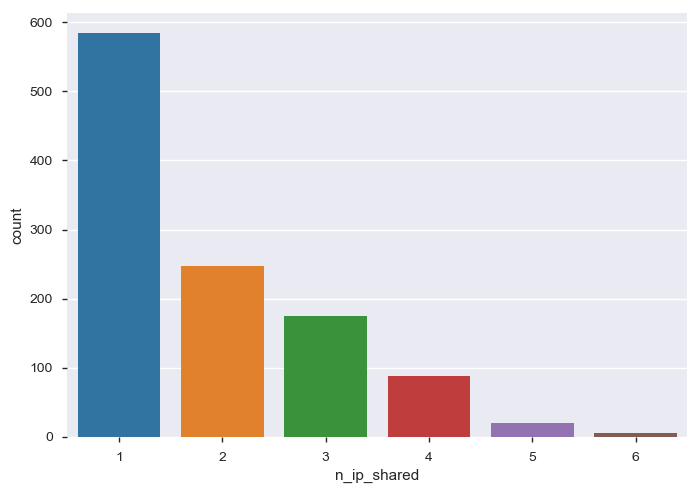

In [263]:
sns.countplot(x="n_ip_shared", data=fraud)

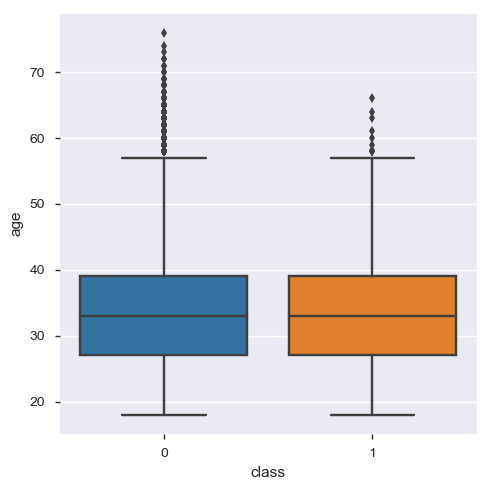

In [237]:
# Deeper dive into age
sns.catplot(x="class", y="age", kind="box",data=fraud_data)

* It can be seen that the range of age of fraud group is smaller, and most of them lower than 60.

In [85]:
fraud_data[fraud_data['class'] == 1].head(100)

,user_id,signup_time,purchase_time,purchase_value,device_id,sex,age,ip_address,class,country,interval_after_signup,signup_days_of_year,signup_seconds_of_day,purchase_days_of_year,purchase_seconds_of_day,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari
136961,86574,2015-01-11 14:39:04,2015-01-11 14:39:05,61,ZQVCVEXPSAZCA,1,23,3.941890e+08,1,United States,1.0,11,52744,11,52745,0,0,1,0,0,0,0,1
136962,74145,2015-03-27 07:55:56,2015-07-20 06:59:34,55,DFQZESNZDEIPP,0,18,1.930175e+09,1,Korea Republic of,9932618.0,86,28556,201,25174,1,0,0,0,1,0,0,0
136963,282058,2015-01-05 08:18:00,2015-01-05 08:18:01,36,EGLGSEGYPMMAM,1,37,3.503224e+09,1,United States,1.0,5,29880,5,29881,0,0,1,0,1,0,0,0
136964,255332,2015-01-01 01:46:58,2015-01-01 01:46:59,19,SQWWBFDRYPGYA,0,36,2.105295e+08,1,United States,1.0,1,6418,1,6419,0,0,1,0,0,1,0,0
136965,399497,2015-01-01 14:29:27,2015-01-22 15:14:12,52,JWAVUHXQXTCHW,1,22,1.052881e+09,1,Nigeria,1817085.0,1,52167,22,54852,0,1,0,1,0,0,0,0
136966,337297,2015-02-10 13:01:00,2015-04-14 05:08:57,50,BCKHXUUTHTMMW,0,31,8.000143e+08,1,Canada,5414877.0,41,46860,104,18537,0,0,1,0,1,0,0,0
136967,46163,2015-03-05 09:23:48,2015-06-03 01:57:00,12,YFFPJJLHEHZML,1,45,1.957369e+09,1,China,7749192.0,64,33828,154,7020,0,1,0,0,0,0,0,1
136968,17097,2015-01-08 10:34:16,2015-01-08 10:34:17,12,IGAXAVAZFJYOB,1,33,2.447058e+09,1,Netherlands,1.0,8,38056,8,38057,1,0,0,0,0,0,0,1
136969,318808,2015-01-02 06:01:09,2015-01-02 06:01:10,22,MLKPWLXKZYANO,0,33,2.543532e+09,1,United States,1.0,2,21669,2,21670,1,0,0,1,0,0,0,0
136970,303431,2015-01-11 19:16:05,2015-01-11 19:16:06,61,SIKJNYXDSEUEG,1,30,3.410478e+09,1,Taiwan; Republic of China (ROC),1.0,11,69365,11,69366,1,0,0,1,0,0,0,0


## Fraud pattern
(a customer has the following features would have a higher probability to make a fraud transaction)

* the purchase time interval after signing-up is less than or equal to 1 second.
* Use one device to make more than 2 transactions by different accounts
* Use a shared ip/public network 



## Recommendation for fraud detection system

In [270]:
t = (10 * probs[:, 1]).astype(int)
unique, counts = np.unique(t, return_counts=True)
print (np.asarray((unique, counts)).T)


[[    0 27513]
 [    1     5]
 [    2     1]
 [    7     1]
 [    8    44]
 [    9    93]
 [   10    19]]


* The probability estimated by GBM model could be transformed into a score for system automatically detect the customer with high risk of fraud. 
* for a customer has a score rangring from 0 - 7, the order could pass to the shipping process
* for a customer has a score 8, the order should be taken manual investigation
* for a customer has a score 9 or 10, the order should be declined